In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np
import pickle

import copy

from agentfil.filecoin_model import FilecoinModel, solve_geometric, distribute_agent_power_geometric_series
from agentfil.agents.dca_agent import DCAAgentTerminate
from agentfil import constants
from mechafil import minting, sim

import numpyro

In [3]:
NDEVICES=2
numpyro.set_host_device_count(NDEVICES)

#simulation_start_date = #datetime.today().date() - timedelta(days=3)
simulation_start_date = date(2024, 5, 1)
forecast_length = 2*365
end_date = simulation_start_date + timedelta(days=forecast_length)

num_agents = 1
agent_power_distributions = distribute_agent_power_geometric_series(num_agents, a=0.35)

auth_token = os.path.join(os.environ['HOME'], 'code/cel/auth/spacescope_auth.json')

print('Simulation Start:', simulation_start_date)

Simulation Start: 2024-05-01


In [4]:
data.setup_spacescope(auth_token)
# get historical data
historical_data_fp = '/tmp/abm/historical_data.pkl'
if not os.path.exists(historical_data_fp):
    historical_stats = data.get_historical_network_stats(
        constants.NETWORK_DATA_START,
        simulation_start_date,
        end_date
    )
    scheduled_df = data.query_sector_expirations(constants.NETWORK_DATA_START, end_date)
    os.makedirs('/tmp/abm',exist_ok=True)
    with open(historical_data_fp, 'wb') as f:
        pickle.dump({
            'historical_stats': historical_stats,
            'scheduled_df': scheduled_df
        }, f)

In [5]:
agent_types = [DCAAgentTerminate] * num_agents
agent_kwargs_vec = []
random_seed_base=1000
rng = np.random.RandomState(random_seed_base)

mean_pow = 6  # 6 PiB/day of RBP
renewal_rate = 0.8
fil_plus_rate = 0.8
terminate_date = date(2023,7,1)
for ii in range(num_agents):
    kwargs = {
        'max_daily_rb_onboard_pib': mean_pow,
        'renewal_rate': renewal_rate,
        'fil_plus_rate': fil_plus_rate,
        'sector_duration': 360,
        'terminate_date': terminate_date,
    }
    agent_kwargs_vec.append(kwargs)

rewards_per_sector_process_kwargs = {
    'forecast_history': 180,
    'update_every_days': 20000,
    'num_warmup_mcmc': 500,
    'num_samples_mcmc': 500,
    'seasonality_mcmc': 1000,
    'num_chains_mcmc': 2,
    'verbose': False,
    'keep_previous_predictions': False,
    'keep_power_predictions': False,   # Setting this to true enables debugging plots but slows down simulation
}
price_process_kwargs = {
    'forecast_num_mc':1000,
    'random_seed':1234
}

filecoin_model = FilecoinModel(num_agents, simulation_start_date, end_date, 
                               spacescope_cfg=auth_token,
                               agent_types=agent_types, agent_kwargs_list=agent_kwargs_vec, 
                               agent_power_distributions=agent_power_distributions,
                               compute_cs_from_networkdatastart=True, use_historical_gas=True,
                               price_process_kwargs=price_process_kwargs,
                               rewards_per_sector_process_kwargs=rewards_per_sector_process_kwargs,
                               renewals_setting='optimistic',
                               offline_historical_data=historical_data_fp
                              )

/home/kiran/code/cel/filecoin-agent-twin/agentfil/filecoin_model.py:178: UserWarning: You are trying to set model.agents. In a next release, this attribute is used by MESA itself so you cannot use it directly anymore.Please adjust your code to use a different attribute name for custom agent storage
  self.agents = []
/home/kiran/anaconda3/envs/agentfil/lib/python3.10/site-packages/mechafil/data.py:153: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  init_baseline_bytes = bp_df[bp_df["date"] >= pd.to_datetime(date, utc="UTC")].iloc[
/home/kiran/anaconda3/envs/agentfil/lib/python3.10/site-packages/mechafil/data.py:170: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-compar

seeding agent 0 with power pct 1.0
Fast forwarding power to simulation start date... 2024-05-01
Computing Scheduled Expirations from:  2024-05-01  to:  2026-04-30
Initializing circulating supply...
Updating circulating supply statistics...
Updating circulating supply statistics... --> start_date: 2021-03-16
Finished updating CS.  Final date -> 2024-04-30


/home/kiran/anaconda3/envs/agentfil/lib/python3.10/site-packages/mechafil/data.py:153: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  init_baseline_bytes = bp_df[bp_df["date"] >= pd.to_datetime(date, utc="UTC")].iloc[


In [6]:
sim_len = (end_date - simulation_start_date).days
for ii in tqdm(range(sim_len)):
    filecoin_model.step()

  0%|          | 0/730 [00:00<?, ?it/s]

In [7]:
#filecoin_model.agents[0]['agent'].agent_info_df
agent = filecoin_model.agents[0]['agent']

cc_onboarded_power_vec, cc_renewed_power_vec, cc_se_power_vec, cc_t_power_vec = [], [], [], []
for ii, p in enumerate(agent.onboarded_power):
    cc_onboarded_power_vec.append(p[0].pib)
    cc_renewed_power_vec.append(agent.renewed_power[ii][0].pib)
    cc_se_power_vec.append(agent.scheduled_expire_power[ii][0].pib)
    cc_t_power_vec.append(agent.terminated_power[ii][0].pib)

cc_onboarded_power_vec = np.asarray(cc_onboarded_power_vec)
cc_renewed_power_vec = np.asarray(cc_renewed_power_vec)
cc_se_power_vec = np.asarray(cc_se_power_vec)
cc_t_power_vec = np.asarray(cc_t_power_vec)

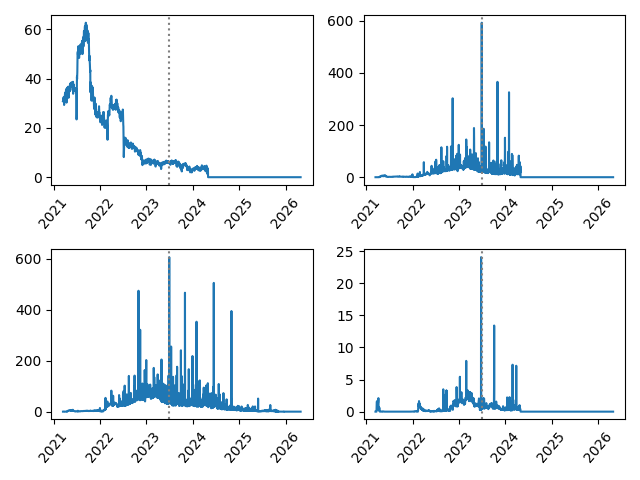

In [8]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(agent.t, cc_onboarded_power_vec)
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=50)

plt.subplot(2,2,2)
plt.plot(agent.t, cc_renewed_power_vec)
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=50)

plt.subplot(2,2,3)
plt.plot(agent.t, cc_se_power_vec)
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=50)

plt.subplot(2,2,4)
plt.plot(agent.t, cc_t_power_vec)
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=50)

plt.tight_layout()

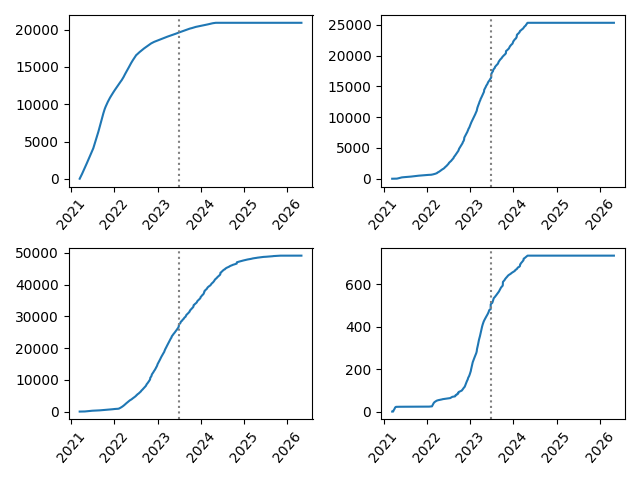

In [9]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(agent.t, cc_onboarded_power_vec.cumsum())
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=50)

plt.subplot(2,2,2)
plt.plot(agent.t, cc_renewed_power_vec.cumsum())
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=50)

plt.subplot(2,2,3)
plt.plot(agent.t, cc_se_power_vec.cumsum())
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=50)

plt.subplot(2,2,4)
plt.plot(agent.t, cc_t_power_vec.cumsum())
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=50)

plt.tight_layout()

0 0 -1890


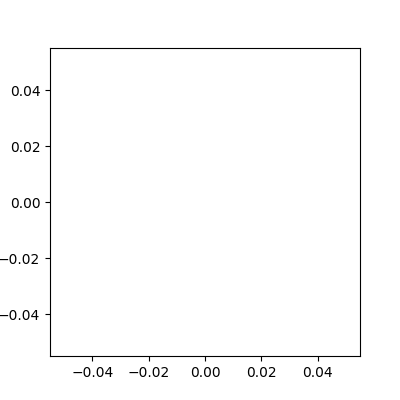

In [10]:
# print(simulation_start_date, end_date)
# agent._trace_onboarded_power(simulation_start_date, date(2025, 6, 1))

# sanity check that we trace modeled power properly
cd = simulation_start_date
rb_active_pwr_total, qa_active_pwr_total = 0, 0
rb_active_pwr_vec = []
qa_active_pwr_vec = []
days_offset = 10
while cd < (terminate_date - timedelta(days=days_offset)):
    rb_active_pwr, qa_active_pwr, _, _, _ = agent._trace_modeled_power(cd, terminate_date-timedelta(days=days_offset))
    rb_active_pwr_total += rb_active_pwr
    qa_active_pwr_total += qa_active_pwr
    
    rb_active_pwr_vec.append(rb_active_pwr)
    qa_active_pwr_vec.append(qa_active_pwr)
    
    cd += timedelta(days=1)
num_days_active = (terminate_date - simulation_start_date).days - days_offset
print(rb_active_pwr_total, qa_active_pwr_total, mean_pow*num_days_active)

plt.figure(figsize=(4,4))
plt.plot(rb_active_pwr_vec)

In [11]:
forecasts_df = filecoin_model.global_forecast_df
update_dates = filecoin_model.minting_process.update_dates
model_df = filecoin_model.filecoin_df
model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]

/tmp/ipykernel_91794/1742197849.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]


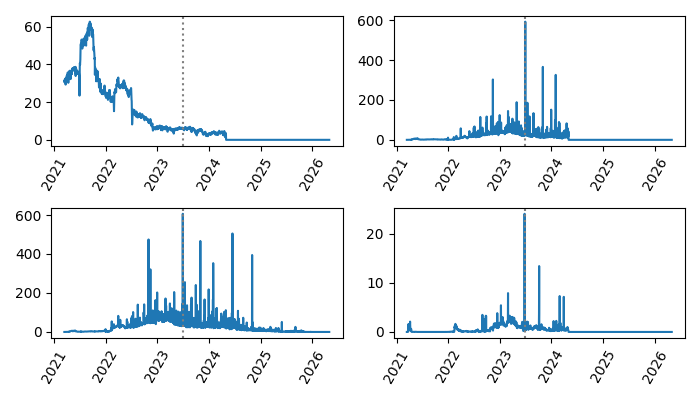

In [12]:
plt.figure(figsize=(7,4))

plt.subplot(2,2,1)
plt.plot(model_df['date'], model_df['day_onboarded_rbp_pib'])
plt.xticks(rotation=60)
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')

plt.subplot(2,2,2)
plt.plot(model_df['date'], model_df['day_renewed_rbp_pib'])
plt.xticks(rotation=60)
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')

plt.subplot(2,2,3)
plt.plot(model_df['date'], model_df['day_sched_expire_rbp_pib'])
plt.xticks(rotation=60)
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')

plt.subplot(2,2,4)
plt.plot(model_df['date'], model_df['day_terminated_rbp_pib'])
plt.xticks(rotation=60)
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')

plt.tight_layout()

In [13]:
model_df[model_df['date']>=terminate_date]['day_sched_expire_rbp_pib'].sum()

21768.890014648438

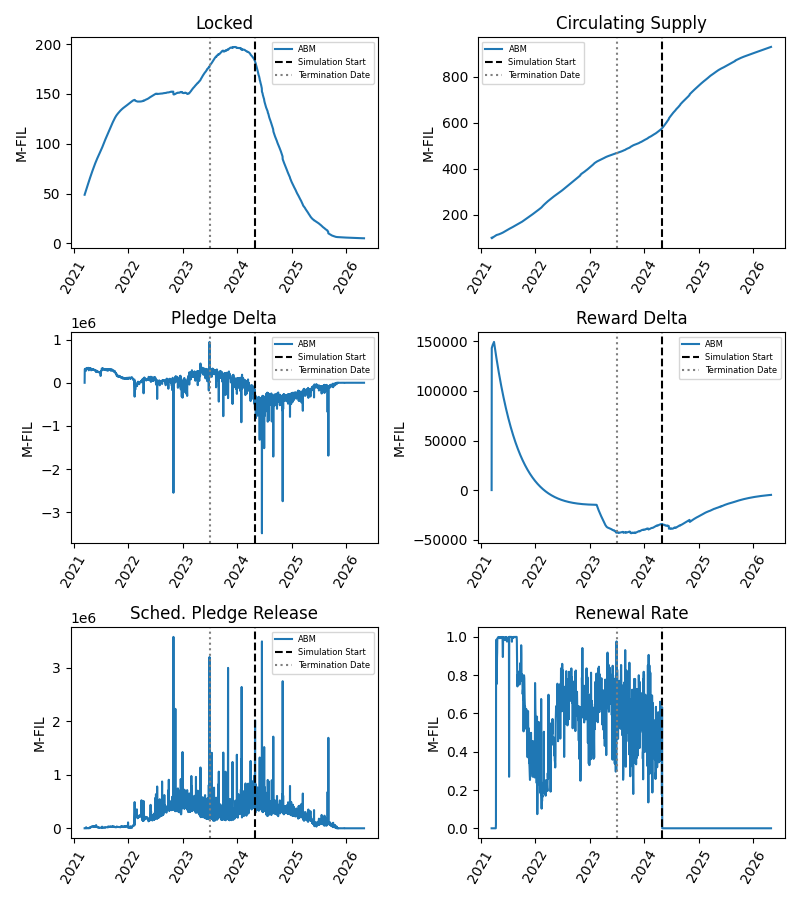

In [14]:
plt.figure(figsize=(8,9))

plt.subplot(3,2,1)
plt.plot(model_df['date'], model_df['network_locked']/1_000_000, label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Locked')
plt.legend(fontsize=6)

plt.subplot(3,2,2)
plt.plot(model_df['date'], model_df['circ_supply']/1_000_000, label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.legend(fontsize=6)

plt.subplot(3,2,3)
plt.plot(model_df['date'], model_df['pledge_delta'], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Pledge Delta')
plt.legend(fontsize=6)

plt.subplot(3,2,4)
plt.plot(model_df['date'], model_df['reward_delta'], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Reward Delta')
plt.legend(fontsize=6)

plt.subplot(3,2,5)
plt.plot(model_df['date'], model_df['scheduled_pledge_release'], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Sched. Pledge Release')
plt.legend(fontsize=6)

plt.subplot(3,2,6)
plt.plot(model_df['date'], model_df['renewal_rate'], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Renewal Rate')

plt.tight_layout()

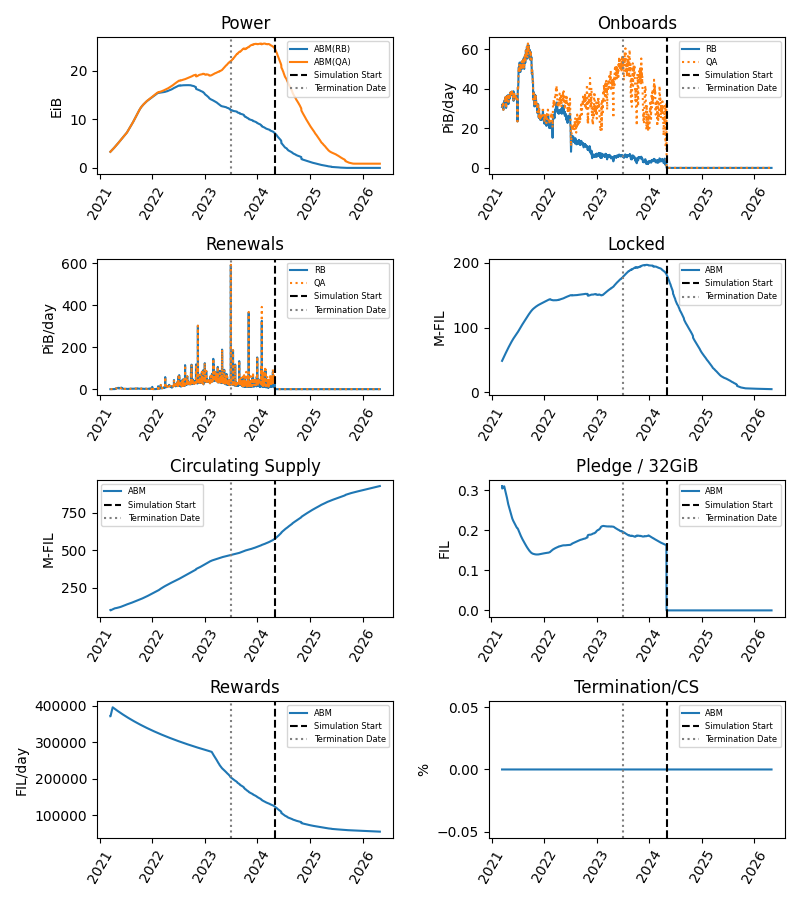

FileNotFoundError: [Errno 2] No such file or directory: '/home/kiran/Documents/hackmd/abm/terminate.png'

In [15]:
plt.figure(figsize=(8,9))
plt.subplot(4,2,1)
plt.plot(model_df['date'], model_df['total_raw_power_eib'], label='ABM(RB)')
plt.plot(model_df['date'], model_df['total_qa_power_eib'], label='ABM(QA)')
# plt.plot(model_df['date'], model_df['network_baseline'] / 2**60, label='Baseline')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.legend(fontsize=6)
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('Power')

plt.subplot(4,2,2)
plt.plot(model_df['date'], model_df['day_onboarded_rbp_pib'], label='RB')
plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'], label='QA', linestyle=':')
# plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'] - mechafil_df['day_onboarded_power_QAP']/PIB, 
#          label='Onboarded[ABM-MechaFIL]')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=60)
plt.title('Onboards')
plt.ylabel('PiB/day')
plt.legend(fontsize=6)

plt.subplot(4,2,3)
plt.plot(model_df['date'], model_df['day_renewed_rbp_pib'], label='RB')
plt.plot(model_df['date'], model_df['day_renewed_qap_pib'], label='QA', linestyle=':')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.xticks(rotation=60)
plt.title('Renewals')
plt.ylabel('PiB/day')
plt.legend(fontsize=6)

plt.subplot(4,2,4)
plt.plot(model_df['date'], model_df['network_locked']/1_000_000, label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Locked')
plt.legend(fontsize=6)

plt.subplot(4,2,5)
plt.plot(model_df['date'], model_df['circ_supply']/1_000_000, label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.legend(fontsize=6)

plt.subplot(4,2,6)
plt.plot(model_df['date'].iloc[1:], model_df['day_pledge_per_QAP'].iloc[1:], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('FIL')
plt.xticks(rotation=60)
plt.title('Pledge / 32GiB')
plt.legend(fontsize=6)

plt.subplot(4,2,7)
plt.plot(model_df['date'], model_df['day_network_reward'], label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('FIL/day')
plt.xticks(rotation=60)
plt.title('Rewards')
plt.legend(fontsize=6)

plt.subplot(4,2,8)
plt.plot(model_df['date'], model_df['burn_from_terminations']/model_df['circ_supply']*100, label='ABM')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.axvline(x=terminate_date, color='gray', linestyle=':', label='Termination Date')
plt.ylabel('%')
plt.xticks(rotation=60)
plt.title('Termination/CS')
plt.legend(fontsize=6)

plt.tight_layout()

plt.show()
plt.savefig(os.path.join(os.environ['HOME'], 'Documents', 'hackmd', 'abm', 'terminate.png'))

In [ ]:
plt.figure(figsize=(8,5))

plt.subplot(2,2,1)
plt.plot(model_df['date'], model_df['total_qa_power_eib'])
plt.xticks(rotation=60)

plt.subplot(2,2,2)
plt.plot(model_df['date'], model_df['day_network_reward'])
plt.xticks(rotation=60)


plt.subplot(2,2,3)
plt.plot(model_df['date'], model_df['day_rewards_per_sector'])
plt.xticks(rotation=60)

plt.tight_layout()

In [ ]:
model_df['burn_from_terminations'].max()